In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binom
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

import sys
sys.path.insert(0, '/net/home/dlee/brca1/bin')
from others import round_sig

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 130)

import calculate_polymorphism as cl

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", palette=None, font_scale=2)
sns.despine(bottom = True, left = True)

<Figure size 432x288 with 0 Axes>

In [3]:
summary_data_dir = "/net/home/dlee/brca1/data/summary_gnomAD/syn_binning/"
denovo_data_dir = "/net/home/dlee/brca1/data/denovo/rate_summary/"

# load gnomAD syn files
carlson_syn = pd.read_csv(summary_data_dir + "fake_exon_variants_syn_dropdup_mono_Carlson_binned.tsv", sep = "\t")
vova_syn = pd.read_csv(summary_data_dir + "fake_exon_variants_syn_dropdup_mono_Vova_rebin.tsv", sep = "\t")
gnomad_syn = pd.read_csv(summary_data_dir + "fake_exon_variants_syn_dropdup_mono_gnomAD_rebin.tsv", sep = "\t")

df_list_syn = [vova_syn, carlson_syn, gnomad_syn]

i = 0

for df in df_list_syn:
    if i == 0:
        df["rate"] = [round_sig(x, 5) for x in df["rate"].astype(float)]
    elif i ==1:
        df["rate"] = [round_sig(x, 3) for x in df["rate"].astype(float)]
    elif i == 2:
        df["rate"] = [round_sig(x, 3) for x in df["rate"].astype(float)]
    df["rate"] = df["rate"].astype(str)
    
    i += 1

In [4]:
carlson_syn = carlson_syn[["polymorphic", "rate", "sites"]].groupby("rate").sum().reset_index()
carlson_syn["rate"] = carlson_syn["rate"].astype(float)
carlson_syn["rate_per_gen"] = 2.086e-09 * carlson_syn["rate"]

In [5]:
rate_column_name = ["mu", "Carlson_rate", "gnomAD_rate"]
poisson_factor = [1.39321487, 0.02290102, 12924299.873437526]

## work on Roulette

In [6]:
poisson_factor = [1.39321487, 0.02290102, 12924299.873437526]

i = 0

df_list_syn = [vova_syn, carlson_syn, gnomad_syn]


for df in df_list_syn:
    df["rate"] = df["rate"].astype(float)

    df["poisson_factor"] = df["rate"] * poisson_factor[i]
    df["p"] = 1 - np.exp(-1*df["poisson_factor"])

    df["prob_bin"] = df["sites"]/df["sites"].sum()
    
    df["monomorphic"] = df["sites"] - df["polymorphic"]
    
    i += 1

## calculate likelihood max

In [7]:
list_of_list = []

for i in range(1000):
    print(i)
    df_vova = cl.simulate(vova_syn)
    df_carlson = cl.simulate(carlson_syn)
    df_gnomad = cl.simulate(gnomad_syn)
    
    max_ll = cl.likelihood_max(df_vova)
    null_ll = cl.likelihood_null(df_vova)
    
    max_R2 = cl.calculate_r2(max_ll, null_ll)
    
    r2_roulette = cl.calculate_r2(cl.calculate_loglikelihood(df_vova), null_ll)
    r2_gnomad = cl.calculate_r2(cl.calculate_loglikelihood(df_gnomad), null_ll)
    r2_carlson = cl.calculate_r2(cl.calculate_loglikelihood(df_carlson), null_ll)
    
    r2_list = [r2_roulette, r2_gnomad, r2_carlson]
    
    list_of_list.append([r2/max_R2 for r2 in r2_list])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
df_r2 = pd.DataFrame(list_of_list, columns = ["Roulette", "gnomAD", "Carlson"])

In [9]:
df_r2.mean()

Roulette    0.907895
gnomAD      0.831594
Carlson     0.861847
dtype: float64

In [10]:
df_r2.quantile(.975)

Roulette    0.910215
gnomAD      0.833844
Carlson     0.864053
Name: 0.975, dtype: float64

In [11]:
df_r2.quantile(.025)

Roulette    0.905544
gnomAD      0.829280
Carlson     0.859569
Name: 0.025, dtype: float64

In [12]:
Roulette: [0.891, 1.0]
gnomAD: [0.810, 1.0]
Carlson: [0.861, 1.0]

## plot

In [16]:
r2_list = [0.907895, 0.861847, 0.831594]
r2_autism_list = [0.9195207978800639, 0.8637592930532756, 0.8474031558390075]
r2_allmut_list = [0.9982636595999121, 0.9614651245040646, 0.9192580985233623]

names = ["Roulette", "Carlson", "gnomAD"]

In [17]:
for i in range(3):
    print(np.mean([r2_autism_list[i], r2_allmut_list[i]]))

0.958892228739988
0.9126122087786701
0.8833306271811849


In [21]:
df_plot = pd.DataFrame(zip(names, r2_list, r2_autism_list, r2_allmut_list), 
                       columns = ["Model", "gnomAD v2", "de novo exome", "de novo genome"])

In [22]:
df_melt = df_plot.melt(id_vars=['Model'], value_vars=["gnomAD v2", "de novo exome", "de novo genome"])

df_melt.rename({"value": "Pseudo R2", "variable": "Dataset"}, axis = 1, inplace = True)

In [23]:
df_melt["1 - Pseudo R2"] = 1 - df_melt["Pseudo R2"]

In [24]:
sns.set_theme(style="white", palette=None, font_scale=2.5)
sns.despine(bottom = True, left = True)

<Figure size 432x288 with 0 Axes>

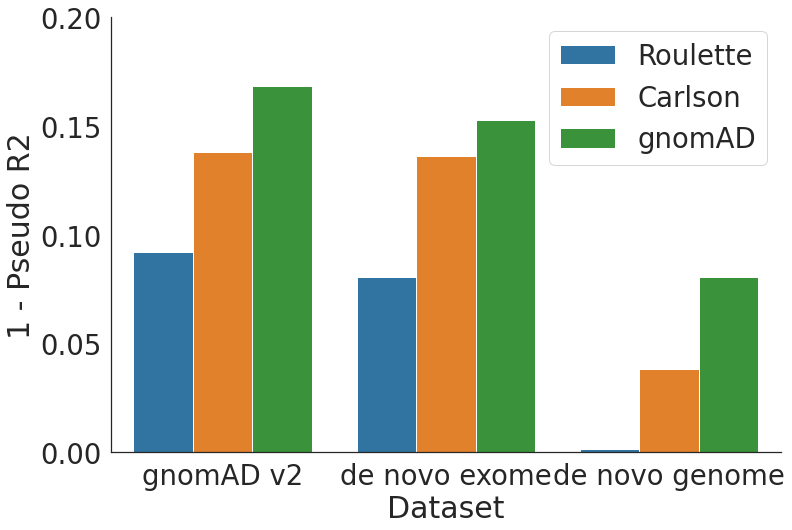

In [25]:
plt.subplots(figsize=(12, 8))
ax = sns.barplot(x='Dataset', y="1 - Pseudo R2", hue='Model', data=df_melt)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0, 0.2)
plt.legend(loc='upper right')


plt.savefig("2a.pdf", format="pdf", bbox_inches="tight")

# for container in ax.containers:
#     ax.bar_label(container)


In [63]:
pal = sns.color_palette()
print(pal.as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [61]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]